In [123]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
df = pd.read_csv("/Users/mdnaif/Desktop/Winter_Arc_ML/Day06_XGBoost/heart_cleveland_upload.csv")

In [125]:
from sklearn.model_selection import train_test_split

cat_coln = ["sex","cp","fbs","restecg","exang","slope","ca","thal"]
num_coln =["age","trestbps","chol","thalach","oldpeak"]

X = df[cat_coln + num_coln]
y = df["condition"]

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2,stratify=y)

In [126]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

preprocessing = ColumnTransformer([
    ("cat_col",OneHotEncoder(handle_unknown="ignore"),cat_coln),
    ("num_col","passthrough",num_coln)
])

pipeline = make_pipeline(
    (preprocessing),
    (XGBClassifier(random_state=42,
                   objective ="binary:logistic",
                   eval_metric = "logloss",
                   tree_method = "hist",))
)

In [127]:
pipeline.named_steps

{'columntransformer': ColumnTransformer(transformers=[('cat_col',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  ['sex', 'cp', 'fbs', 'restecg', 'exang',
                                   'slope', 'ca', 'thal']),
                                 ('num_col', 'passthrough',
                                  ['age', 'trestbps', 'chol', 'thalach',
                                   'oldpeak'])]),
 'xgbclassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_oneho

In [128]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [129]:
from sklearn.model_selection import RandomizedSearchCV

param_distribution = {
    "xgbclassifier__learning_rate": [0.1, 0.05, 0.01],
    "xgbclassifier__max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "xgbclassifier__n_estimators": [200,300,400,500,600,700,800,900,1000],
    "xgbclassifier__colsample_bytree": [0.6, 0.8, 1.0],
    "xgbclassifier__subsample": [0.6, 0.7, 0.8, 0.9],
    "xgbclassifier__min_child_weight": [1,2,3,4,5],
}

grid = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distribution,
    scoring="f1",
    cv=cv,
    n_iter= 50,
    n_jobs= -1,
    verbose=1
)

grid.fit(X_train,y_train)

best_model = grid.best_estimator_
print(grid.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'xgbclassifier__subsample': 0.6, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__colsample_bytree': 0.6}


In [130]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

y_pred = best_model.predict(X_test)

print(f"Acccuracy : \n{accuracy_score(y_test,y_pred)}\n")
print(f"Confusion_matrix : \n{confusion_matrix(y_test,y_pred)}\n")
print(f"Classification_report : \n{classification_report(y_test,y_pred)}\n")

Acccuracy : 
0.8666666666666667

Confusion_matrix : 
[[30  2]
 [ 6 22]]

Classification_report : 
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        32
           1       0.92      0.79      0.85        28

    accuracy                           0.87        60
   macro avg       0.88      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60




In [131]:
print("Train acc:", best_model.score(X_train, y_train))
print("Test acc :", best_model.score(X_test, y_test))

Train acc: 0.8776371308016878
Test acc : 0.8666666666666667


### SMOTE

In [132]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)

X_train_resampled , y_train_resampled = smote.fit_resample(X_train,y_train)

print(f"Original shape: {y_train.value_counts()}")
print(f"Resampled shape: {y_train_resampled.value_counts()}")

Original shape: condition
0    128
1    109
Name: count, dtype: int64
Resampled shape: condition
1    128
0    128
Name: count, dtype: int64


In [133]:
best_model_resampled = grid.best_estimator_
best_model_resampled.fit(X_train_resampled, y_train_resampled)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('xgbclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat_col', ...), ('num_col', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the diff

In [134]:
y_pred_smote = best_model_resampled.predict(X_test)
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        32
           1       0.91      0.75      0.82        28

    accuracy                           0.85        60
   macro avg       0.86      0.84      0.85        60
weighted avg       0.86      0.85      0.85        60



In [135]:
from sklearn.metrics import roc_auc_score , roc_curve

y_prob = best_model_resampled.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_prob)


0.9609375

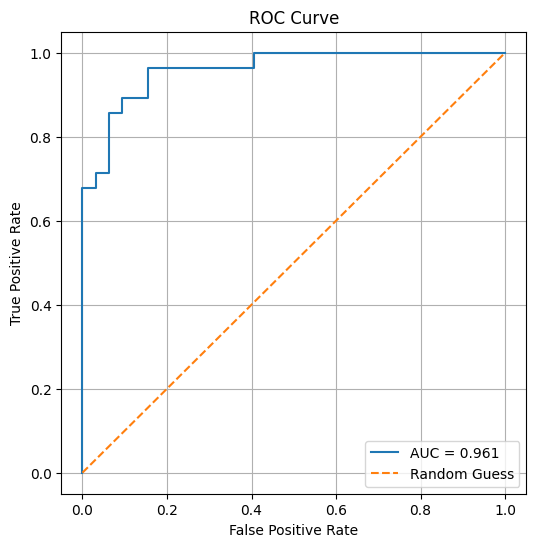

In [136]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [137]:
import pickle
with open("xgboost_heart_disease_model.pkl","wb") as f:
    pickle.dump(best_model_resampled,f)
print ("Model saved successfully.")

Model saved successfully.
